In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
d_jan = extract.get_data()
d_jan = extract.clean_data(d_jan)

/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [43]:
d_new = pd.read_csv('./data/EMMA_new_data.csv', usecols = ['cusip', 'price', 'yield', 'tradedate', 'tradetype', 'name', 'state', 'RTG_Moody', 'RTG_SP', 'coupon', 'maturity',
'issuetype', 'issuesource'])
d_new.columns = [s.lower() for s in d_new.columns]

In [44]:
d_new.state = d_new.state.apply(lambda x: x[0].upper() + x[1:])

In [45]:
d_new = extract.clean_data(d_new)

In [46]:
d_new.issuetype = d_new.issuetype.apply(lambda x: x.upper())
d_new.issuesource = d_new.issuesource.apply(lambda x: x.upper())

In [47]:
d_new.loc[d_new.tradetype == 'Customer sold', 'tradetype'] = 'Purchase_from_Customer'
d_new.loc[d_new.tradetype == 'Customer bought', 'tradetype'] = 'Sale_to_Customer'

In [54]:
d_new.columns
d_new.shape
d_new.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            398, 399, 400, 401, 402, 403, 404, 405, 406, 407],
           dtype='int64', length=408)

In [55]:
d_jan.columns
d_jan.shape
d_jan.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            35446, 35447, 35448, 35449, 35450, 35451, 35452, 35453, 35454,
            35455],
           dtype='int64', length=35456)

In [84]:
d_combined = pd.concat([d_jan, d_new], axis = 0, join = 'outer')
d_combined.index = range(d_combined.shape[0])

In [85]:
# embed text features of d_combined
d_combined_1 = d_combined.drop(['amount', 'bidcount', 'issuesize', 'tradeid'], axis = 1)
d_combined_state_features = extract.build_state_features(d_combined_1, num_states = None)
d_combined_other_features = extract.build_other_text_features(d_combined_1)
d_t = pd.concat([d_combined_1.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), d_combined_state_features, d_combined_other_features], axis = 1)

In [86]:
d_t.head()

,coupon,cusip,maturity,name,price,rtg,tradedate,yield,Alabama,Alaska,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype
0,4.00,45471AKG6,6635.0,indiana st fin auth-a,99.507,6,2.0,4.037,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4.00,45471AKG6,6635.0,indiana st fin auth-a,99.410,6,2.0,4.045,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.00,45471AKG6,6635.0,indiana st fin auth-a,99.290,6,2.0,4.054,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.25,45471AMY5,6423.0,in fin auth-major,103.145,9,2.0,3.717,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5.00,4550572N8,2894.0,in fin auth-ref-a,114.082,1,2.0,2.060,0,0,...,0,0,0,0,0,0,0,0,1,1


In [88]:
d_jan_t = d_t.loc[:d_jan.shape[0]-1, :]
d_new_t = d_t.loc[d_jan.shape[0]:, :]

In [91]:
s_jan = extract.compile_price_change_data(d_jan_t, {'purchase': 1, 'sell': 0})
s_new = extract.compile_price_change_data(d_new_t, {'purchase': 1, 'sell': 0})

extract.compile_price_change_data: finished cusip 0 of 5
extract.compile_price_change_data: finished cusip 1 of 5
extract.compile_price_change_data: finished cusip 2 of 5
extract.compile_price_change_data: finished cusip 3 of 5
extract.compile_price_change_data: finished cusip 4 of 5


In [95]:
s_new.head()

,coupon,cusip,maturity,name,price,rtg,tradedate,yield,Alabama,Alaska,...,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype,dprice,holdtime,d_index
0,4.0,13080SMW1,0.0,ca stwd cmntys-a-ref,100.0,5,37.619444,3.999,0,0,...,0,0,0,0,0,0,1,-2.060,7.912500,35577
1,4.0,13080SMW1,0.0,ca stwd cmntys-a-ref,100.0,5,37.619444,3.999,0,0,...,0,0,0,0,0,0,1,-2.060,7.925694,35577
2,4.0,13080SMW1,0.0,ca stwd cmntys-a-ref,100.0,5,37.619444,3.999,0,0,...,0,0,0,0,0,0,1,-3.475,7.942361,35577
3,4.0,13080SMW1,0.0,ca stwd cmntys-a-ref,100.0,5,37.619444,3.999,0,0,...,0,0,0,0,0,0,1,-2.060,7.971528,35577
4,4.0,13080SMW1,0.0,ca stwd cmntys-a-ref,100.0,5,37.619444,3.999,0,0,...,0,0,0,0,0,0,1,-2.060,7.999306,35577


In [96]:
dprice_jan = s_jan.pop('dprice')
dprice_new = s_new.pop('dprice')

In [97]:
d_index_jan = s_jan.pop('d_index')
d_index_new = s_new.pop('d_index')
s_jan_1 = s_jan.drop(['tradetype', 'cusip', 'name', 'yield'], axis = 1)
s_new_1 = s_new.drop(['tradetype', 'cusip', 'name', 'yield'], axis = 1)

In [98]:
s_jan_1.head()

,coupon,maturity,price,rtg,tradedate,Alabama,Alaska,Arizona,Arkansas,California,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,holdtime
0,4.0,6635.0,99.507,6,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,4.0,6635.0,99.507,6,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,4.0,6635.0,99.507,6,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
3,4.0,6635.0,99.507,6,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
4,4.0,6635.0,99.507,6,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0


In [111]:
clf = RandomForestRegressor(max_depth = 10, n_estimators = 50)

In [113]:
clf.fit(s_jan_1, dprice_jan)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

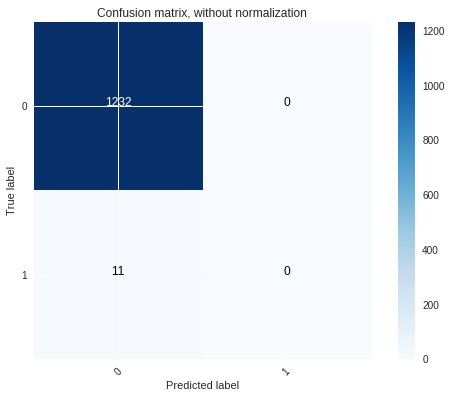

In [115]:
dp_predict = clf.predict(s_new_1)
#dp_predict_old = clf.predict(s_jan_1)
cnf_matrix = confusion_matrix((dprice_new>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [102]:
dprice_new[dprice_new > 0]

177     0.281
192     0.375
223     0.176
229     0.075
951     0.266
956     0.334
962     0.724
966     0.722
967     0.030
1062    0.079
1066    0.077
Name: dprice, dtype: float64

96.525000000000006

100.7

In [106]:
np.sqrt(np.sum((dp_predict - dprice_new.values)**2)/dprice_new.shape[0])

1.4072970650219945

In [107]:
dp_predict[:10]

array([-0.29416135, -0.29416135, -0.29416135, -0.29416135, -0.29416135,
       -0.29858335, -0.29858335, -0.29858335, -0.34630401, -0.26251347])

In [108]:
dprice_new[:10]

0   -2.060
1   -2.060
2   -3.475
3   -2.060
4   -2.060
5   -2.000
6   -2.000
7   -2.000
8   -1.750
9   -2.060
Name: dprice, dtype: float64

In [117]:
s_jan.columns

Index([u'coupon', u'cusip', u'maturity', u'name', u'price', u'rtg',
       u'tradedate', u'yield', u'Alabama', u'Alaska',
       ...
       u'SPECIAL TAX', u'STUDENT LOAN REVENUE', u'TAX INCRMT./ALLCTN.REV.',
       u'TELECOM REVENUE', u'TOBACCO & LIQUOR TAXES',
       u'TOBACCO SETTLEMENT FUNDED', u'TRANSIT REVENUE', u'WATER REVENUE',
       u'tradetype', u'holdtime'],
      dtype='object', length=114)

In [118]:
dprice_jan[:10]

0   -0.762
1    0.376
2    0.473
3    1.614
4    1.272
5   -0.211
6    0.126
7   -0.306
8   -2.240
9   -0.665
Name: dprice, dtype: float64

In [119]:
dprice_jan.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            77175, 77176, 77177, 77178, 77179, 77180, 77181, 77182, 77183,
            77184],
           dtype='int64', length=77185)

In [120]:
s_jan.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            77175, 77176, 77177, 77178, 77179, 77180, 77181, 77182, 77183,
            77184],
           dtype='int64', length=77185)

In [152]:
r = -float('infinity')
for s in s_jan.cusip.unique():
    I = s_jan.cusip == s
    n = dprice_jan[I].mean()*np.sum(dprice_jan[I] > 0)
    if n > r:
        r = n
        s_best = s
        

In [153]:
s_best

'57563RNV7'

In [154]:
r

49.280923664122113

In [155]:
P = dprice_jan[s_jan.cusip == s_best]

In [156]:
np.sum(P < 0)

51

In [157]:
np.sum(P > 0)

79

In [158]:
P.mean()

0.62380916030534317

In [159]:
P.mean()*np.sum(P>0)

49.280923664122113